# Neural Networks Homework 
***
**Name**: $<$Xu Han$>$ 
***

This assignment is due on Moodle by **11:59pm on Wednesday May 2nd**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)

**NOTES**: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function API **do not** change it.  If we do not provide a function API then you're free to structure your code however you like. 
- Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. 

In [1]:
import pickle, gzip
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

### [30 points] Problem 1: Building and Training a Feed-Forward Neural Network 
***

In this problem you'll implement a general feed-forward neural network class that utilizes sigmoid activation functions. Your tasks will be to implement `forward propagation`, `prediction`, `back propagation`, `gradient_checking`, and a general `train` routine to learn the weights in your network via Stochastic Gradient Descent.  

The skeleton for the `Network` class is below. Note that this class is almost identical to the one you worked with in the **Lecture 18** in-class notebook, so you should look there to remind yourself of the details.   Scroll down to find more information about your tasks as well as unit tests. 

**Important Note**: In **Problem 2** we'll be using the `Network` class to train a network to do handwritten digit recognition.  Please make sure to utilize vectorized Numpy routines as much as possible, as writing inefficient code here will cause very slow training times in **Problem 2**. 

In [2]:
class Network:
    def __init__(self, sizes):
        """
        Initialize the neural network 
        
        :param sizes: a list of the number of neurons in each layer 
        """
        # save the number of layers in the network 
        self.L = len(sizes) 
        
        # store the list of layer sizes 
        self.sizes = sizes  
        
        # initialize the bias vectors for each hidden and output layer 
        self.b = [np.random.randn(n) for n in self.sizes[1:]]
        
        # initialize the matrices of weights for each hidden and output layer 
        self.W = [np.random.randn(n, m) for (m,n) in zip(self.sizes[:-1], self.sizes[1:])]
        
        # initialize the derivatives of biases for backprop 
        self.db = [np.zeros(n) for n in self.sizes[1:]]
        
        # initialize the derivatives of weights for backprop 
        self.dW = [np.zeros((n, m)) for (m,n) in zip(self.sizes[:-1], self.sizes[1:])]
        
        # initialize the activities on each hidden and output layer 
        self.z = [np.zeros(n) for n in self.sizes]
        
        # initialize the activations on each hidden and output layer 
        self.a = [np.zeros(n) for n in self.sizes]
        
        # initialize the deltas on each hidden and output layer 
        self.delta = [np.zeros(n) for n in self.sizes]
        
    def g(self, z):
        """
        sigmoid activation function 
        
        :param z: vector of activities to apply activation to 
        """
        z = np.clip(z, -20, 20)
        return 1.0/(1.0 + np.exp(-z))
    
    def g_prime(self, z):
        """
        derivative of sigmoid activation function 
        
        :param z: vector of activities to apply derivative of activation to 
        """
        return self.g(z) * (1.0 - self.g(z))
    
    def C(self, a, y):
        """
        evaluate the cost function for squared-loss C(a,y) = ||a-y||^2/2 
        
        :param a: activations on output layer 
        :param y: vector-encoded label 
        """
        return 0.5 * np.linalg.norm(a - y)**2
    
    def gradC(self, a, y):
        """
        evaluate gradient of cost function for squared-loss C(a,y) = ||a-y||^2/2 
        
        :param a: activations on output layer 
        :param y: vector-encoded label 
        """
        return (a - y)
    
    def forward_prop(self, x):
        """
        take an feature vector and propagate through network 
        
        :param x: input feature vector 
        """
        
        # TODO: Initialize activation on initial layer to x 
        self.a[0]=x
        
        # TODO: Loop over layers and compute activities and activations 
            
        #self.a = self.a
        for i in range(self.L-1):
            self.z[i+1]=np.matmul(self.W[i],self.a[i])+self.b[i]
            self.a[i+1]=self.g(self.z[i+1])
        return self.a[-1]
    
    def predict(self, X):
        """
        Predicts on the the data in X. Assume at least two output neurons so predictions
        are one-hot encoded vectorized labels. 
        
        :param X: a matrix of data to make predictions on 
        :return y: a matrix of vectorized labels 
        """
        
        yhat = np.zeros((X.shape[0], self.sizes[-1]), dtype=int)
        
        # TODO: Populate yhat with one-hot-coded predictions 
        for i in range(X.shape[0]):
            output=self.forward_prop(X[i])
            yhat[i][np.argmax(output,axis=0)]=1
            
        return yhat 
    
    def accuracy(self, X, y):
        """
        compute accuracy on labeled training set 

        :param X: matrix of features 
        :param y: matrix of vectorized true labels 
        """
        yhat = self.predict(X)
        return np.sum(np.all(np.equal(yhat, y), axis=1)) / X.shape[0]
            
            
    def back_prop(self, x, y):
        """
        Back propagation to get derivatives of C wrt weights and biases for given training example
        
        :param x: training features  
        :param y: vector-encoded label 
        """
        
        # TODO: forward prop training example to fill in activities and activations 
        forward_x=self.forward_prop(x)
        
        # TODO: compute deltas on output layer 
        delta_bp=self.gradC(forward_x,y)
        g_prime_bp=self.g_prime(self.z[self.L-1])
        self.delta[self.L-1]=np.multiply(delta_bp,g_prime_bp)
        
        # TODO: loop backward through layers, backprop deltas, compute dWs and dbs
        for i in range(self.L-2, -1, -1):
            self.dW[i]=np.outer(self.delta[i+1],np.array([self.a[i]]).T)
            self.db[i]=self.delta[i+1]
            self.delta[i]=np.multiply(np.matmul(np.transpose(self.W[i]),self.delta[i+1]),self.g_prime(self.z[i]))
        
    def gradient_checking(self, X_train, y_train, EPS=0.0001):
        """
        Performs gradient checking on all weights in the 
        network for a randomly selected training example 
        :param X_train: matrix of training features 
        :param y_train: matrix of vector-encoded training labels 
        """
        # Randomly select a training example 
        kk = np.random.randint(0,X_train.shape[0])
        xk = X_train[kk]
        yk = y_train[kk]

        # Get the analytic(ish) weights from back_prop 
        self.back_prop(xk, yk)

        # List of relative errors.  Used only for unit testing. 
        rel_errors = []

        # Loop over and perturb each weight/bias in 
        # network and test numerical derivative 
        # Don't forget that after perturbing the weights
        # you'll want to put them back the way they were! 
        
        # Loop over and perturb each weight/bias in 
        # network and test numerical derivative 
        for ell in range(self.L-1):
            for ii in range(self.W[ell].shape[0]):
                # Check weights in level W[ell][ii,jj] 
                for jj in range(self.W[ell].shape[1]):
                    
                    # TODO true_dW
                    true_dW = self.dW[ell][ii,jj]
                    # TODO num_dW  
                    self.W[ell][ii,jj] += EPS
                    a1=self.forward_prop(xk)
                    C1 = self.C(a1,yk)
                    self.W[ell][ii,jj] -= 2*EPS
                    a2=self.forward_prop(xk)
                    C2 = self.C(a2,yk)
                    num_dW = (C1-C2)/(2*EPS)
                    self.W[ell][ii,jj] += EPS
                    
                    rel_dW = np.abs(true_dW-num_dW)/np.abs(true_dW)
                    print("W[{:d}][{:d},{:d}]: true: {: 12.10e}  approx: {: 12.10e} rel_err: {: 12.10e}".format(ell, ii, jj, true_dW, num_dW, rel_dW))
                    rel_errors.append(rel_dW)
                    
                # Check bias b[ell][ii]
                
                # TODO true_db 
                true_db=self.db[ell][ii]
                # TODO num_db  
                self.b[ell][ii] += EPS
                a1_db=self.forward_prop(xk)
                C1_db = self.C(a1_db,yk)
                self.b[ell][ii] -= 2*EPS
                a2_db=self.forward_prop(xk)
                C2_db = self.C(a2_db,yk)
                num_db = (C1_db-C2_db)/(2*EPS)
                self.b[ell][ii] += EPS
                
                rel_db = np.abs(true_db-num_db)/np.abs(true_db)
                print("b[{:d}][{:d}]:   true: {: 12.10e}  approx: {: 12.10e} rel_err: {: 12.10e}".format(ell, ii, true_db, num_db, rel_db))
                rel_errors.append(rel_db)

        return rel_errors
            
            
    def train(self, X_train, y_train, X_valid=None, y_valid=None, eta=0.25, lam=0.0, num_epochs=10, isPrint=True, isTen=True):
        """
        Train the network with SGD 
        
        :param X_train: matrix of training features 
        :param y_train: matrix of vector-encoded training labels 
        :param X_train: optional matrix of validation features 
        :param y_train: optional matrix of vector-encoded validation labels 
        :param eta: learning rate 
        :param lam: regularization strength 
        :param num_epochs: number of epochs to run 
        :param isPrint: flag indicating to print training progress or not 
        """
        self.epoch=[]
        self.acc=[]
        # initialize shuffled indices 
        shuffled_inds = list(range(X_train.shape[0]))
        
        # loop over training epochs 
        for ep in range(num_epochs):
            
            # shuffle indices 
            np.random.shuffle(shuffled_inds)
            
            # loop over training examples 
            for ind in shuffled_inds:
                
                # TODO: back prop to get derivatives 
                self.back_prop(X_train[ind],y_train[ind])
                # TODO: update weights and biases 
                for ll in range(self.L-2, -1, -1):
                    self.W[ll] = self.W[ll]*(1-eta*lam) - eta*self.dW[ll]
                    self.b[ll] = self.b[ll] - eta*self.delta[ll+1]
                
            # occasionally print accuracy
            if(isTen):
                if isPrint and ((ep+1)%10)==1:
                    self.epoch_report(ep, num_epochs, X_train, y_train, X_valid, y_valid)
                    self.epoch.append(ep+1)
                    self.acc.append(self.accuracy(X_valid, y_valid))
            else:
                if isPrint and ((ep+1)%5)==1:
                    self.epoch_report(ep, num_epochs, X_train, y_train, X_valid, y_valid)
                    self.epoch.append(ep+1)
                    self.acc.append(self.accuracy(X_valid, y_valid))
                
        # print final accuracy
        if isPrint:
            self.epoch_report(ep, num_epochs, X_train, y_train, X_valid, y_valid)
                
                    
    def epoch_report(self, ep, num_epochs, X_train, y_train, X_valid, y_valid):
        """
        Print the accuracy for the given epoch on training and validation data 
        
        :param ep: the current epoch 
        :param num_epochs: the total number of epochs
        :param X_train: matrix of training features 
        :param y_train: matrix of vector-encoded training labels 
        :param X_train: optional matrix of validation features 
        :param y_train: optional matrix of vector-encoded validation labels 
        """
        
        print("epoch {:3d}/{:3d}: ".format(ep+1, num_epochs), end="")
        print("  train acc: {:8.3f}".format(self.accuracy(X_train, y_train)), end="")
        if X_valid is not None: print("  valid acc: {:8.3f}".format(self.accuracy(X_valid, y_valid)))
        else: print("")   
    

**Part A**: Complete the `forward_prop` function in the `Network` class to implement forward propagation.  Your function should take in a single training example `x` and propagate it forward in the network, setting the activations and activities on the hidden and output layers.  When you think you're done, execute the following unit test. 

In [4]:
%run -i nn_tests.py "prob 1A"

testForwardProp (__main__.TestNN) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.122s

OK


**Part B**: Complete the `predict` function in the `Network` class to take in a matrix of features and return a matrix of one-hot-encoded label predictions. Your one-hot-encoded predictions should correspond to the output neuron with the largest activation.   

When you think your `predict` function is working well, execute the following unit test. 

In [5]:
%run -i nn_tests.py "prob 1B"

testPredict (__main__.TestNN) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


**Part C**: OK, now it's time to implement back propagation.  Complete the function ``back_prop`` in the ``Network`` class to use a single training example to compute the derivatives of the loss function with respect to the weights and the biases. As in the **Lecture 18** in-class notebook, you may assume that the loss function for a single training example is given by 

$$
C(y, {\bf a}^L) = \frac{1}{2}\|y - {\bf a}^L\|^2  
$$

When you think you're done, execute the following unit test. 

In [6]:
%run -i nn_tests.py "prob 1C"

testBackProp (__main__.TestNN) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


**Part D**: Due to the fact that we hard-code our various activation functions, cost functions, and their derivatives, it is vital to do some debugging to make sure we haven't made a mistake.  

One common technique is to do **numerical gradient checking**.  In this method we compute numerical approximations of the derivatives of the cost function with respect to the model parameters and compare them to the analytic versions computed by back prop.  

Consider a cost function $C$ which is a function of all of the weights and biases in the network.  We can estimate the derivative of $C$ with respect to a particular parameter using a numerical finite difference technique.  This process looks as follows 

$$
\frac{\partial C}{\partial w_i} \approx \frac{C(w_1,\ldots, w_i+\epsilon, \ldots w_N) - C(w_1,\ldots, w_i-\epsilon, \ldots w_N)}{2\epsilon}
$$

Evaluating the cost function with the perturbed weights can be accomplished by randomly choosing a training example, performing forward propagation, and then evaluating the cost function using the activations in the output layer.  

I've given you starter code down below to do numerical gradient checking.  The code will compute the true and numerical values of the derivative of $C$ with respect to each parameter in the network and then plot the pairs of values as well as their relative errors.  Note that in practice this is extremely expensive, and we typically only check a few random parameters. 

When you believe your code is correct, you can test it by executing the following cell. Note that a good rule of thumb is to train the network for a handful of epochs before doing the gradient checking, to avoid any transient behavior that might occur at the very beginning of the training process. 

In [7]:
%run -i nn_tests.py "prob 1D"

testGradCheck (__main__.TestNN) ... 

W[0][0,0]: true: -1.6129176665e-02  approx: -1.6129176655e-02 rel_err:  6.2758809415e-10
W[0][0,1]: true: -3.2258353331e-02  approx: -3.2258353251e-02 rel_err:  2.4817827221e-09
b[0][0]:   true: -1.6129176665e-02  approx: -1.6129176655e-02 rel_err:  6.2758809415e-10
W[0][1,0]: true:  1.0259238746e-02  approx:  1.0259238739e-02 rel_err:  6.6307893984e-10
W[0][1,1]: true:  2.0518477492e-02  approx:  2.0518477439e-02 rel_err:  2.5974560468e-09
b[0][1]:   true:  1.0259238746e-02  approx:  1.0259238739e-02 rel_err:  6.6307893984e-10
W[0][2,0]: true: -5.1903568015e-04  approx: -5.1903567999e-04 rel_err:  3.0985203531e-10
W[0][2,1]: true: -1.0380713603e-03  approx: -1.0380713582e-03 rel_err:  2.0477984656e-09
b[0][2]:   true: -5.1903568015e-04  approx: -5.1903567999e-04 rel_err:  3.0985203531e-10
W[1][0,0]: true: -7.1372985374e-02  approx: -7.1372985357e-02 rel_err:  2.3383240182e-10
W[1][0,1]: true: -4.3055527018e-02  approx: -4.3055527015e-02 rel_err:  8.6212384741e-11
W[1][0,2]: true: -7.8

ok

----------------------------------------------------------------------
Ran 1 test in 0.008s

OK


**Part E**: OK, now let's actually train a neural net!  Complete the missing code in ``train`` to loop over the training data in random order, call `back_prop` to get the derivatives, and then update the weights and the biases via SGD.  When you think you're done, execute the following code

In [8]:
%run -i nn_tests.py "prob 1E"

testSGD (__main__.TestNN) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


**Part F**: Last but not least, we should implement $\ell$-$2$ regularization.  Modify your `train` function to incorporate regularization of the weights (but **not** the biases) in your SGD update.  As in the Lecture 18 slides, you should assume that the cost function with regularization takes the form 

$$
C_\lambda = C + \frac{\lambda}{2} \displaystyle\sum_{w} w^2
$$

where $\sum_{w}$ sums over each weight in all layers of the network. Think carefully before you go making large changes to your code.  This modification is much simpler than you think. When you think you're done, execute the following unit test.  (Then go back and execute the test in **Part C** to make sure you didn't break anything.) 

In [9]:
%run -i nn_tests.py "prob 1F"

testRegularizedSGD (__main__.TestNN) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


### [20 points] Problem 2: A Neural Network Classifier for Handwritten Digit Recognition 
***

In this problem you'll use the Feed-Forward Neural Network framework you wrote in **Problem 1** to take an image of a handwritten digit and predict which digit it corresponds to.  

![Samples of Handwritten Digits](mnist.png "MNIST Digits")

To keep run times down we'll again only consider the subset of the MNIST data set consisting of the digits $3, 7, 8$ and $9$. 

**Part A**: Executing the following cells will load training and validation data and plot an example handwritten digit.  Explore the training and validation sets and answer the following questions: 

- How many pixels are in each image in the data set?  
- How do the true labels correspond to the associated one-hot-encoded label vectors? 
- Give an example of a network architecture with a single hidden layer that is compatible with this data. 


In [10]:
X_train, y_train, X_valid, y_valid = pickle.load(gzip.open("../data/mnist21x21_3789_one_hot.pklz", "rb"))

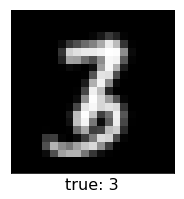

In [24]:
def view_digit(x, label=None):
    fig = plt.figure(figsize=(3,3))
    plt.imshow(x.reshape(21,21), cmap='gray');
    plt.xticks([]); plt.yticks([]);
    if label: plt.xlabel("true: {}".format(label), fontsize=16)
        
training_index = 2
label_dict = dict({0:3, 1:7, 2:8, 3:9})
view_digit(X_train[training_index], label_dict[np.argmax(y_train[training_index])])

In [27]:
print('There are',X_train[0].size, 'pixels in each image in the dataset')

There are 441 pixels in each image in the dataset


Label of the 1st image in validation set: [0 1 0 0]


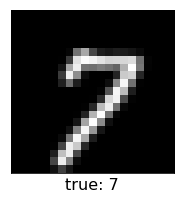

In [32]:
print('The vector of image 7:',y_train[0])
view_digit(X_train[0], label_dict[np.argmax(y_train[0])])

Label of the 1st image in validation set: [0 0 0 1]


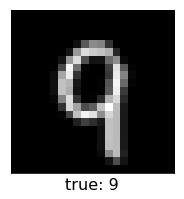

In [34]:
print('The vector of image 9:',y_train[1])
view_digit(X_train[1], label_dict[np.argmax(y_train[1])])

 [1 0 0 0]


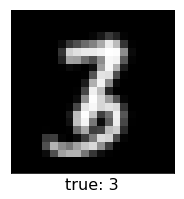

In [35]:
print('',y_train[2])
view_digit(X_train[2], label_dict[np.argmax(y_train[2])])

Label of the 1st image in validation set: [0 0 1 0]


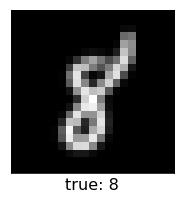

In [38]:
print('Label of the 1st image in validation set:',y_train[5])
view_digit(X_train[5], label_dict[np.argmax(y_train[5])])

From the above results we can see that [1 0 0 0 ] represents the image with true label 3,[0 1 0 0 ] represents the image with true label 7, [0 0 1 0 ] represents the image with true label 8, [0 0 0 1 ] represents the image with true label 9.

In [57]:
NN=Network([441,30,4]) #single hidden layer
NN.train(X_train[0:500], y_train[0:500], X_valid=X_valid, y_valid=y_valid, eta=0.01, lam=0.0, num_epochs=50, isPrint=True, isTen=True)

epoch   1/100:   train acc:    0.234  valid acc:    0.250
epoch  11/100:   train acc:    0.366  valid acc:    0.386
epoch  21/100:   train acc:    0.580  valid acc:    0.590
epoch  31/100:   train acc:    0.628  valid acc:    0.625
epoch  41/100:   train acc:    0.668  valid acc:    0.669
epoch  51/100:   train acc:    0.730  valid acc:    0.718
epoch  61/100:   train acc:    0.818  valid acc:    0.809
epoch  71/100:   train acc:    0.862  valid acc:    0.845
epoch  81/100:   train acc:    0.876  valid acc:    0.862
epoch  91/100:   train acc:    0.898  valid acc:    0.875
epoch 100/100:   train acc:    0.910  valid acc:    0.878


This network -- the first layer has 441 neurons(matches with the number of pixels), the only hidden layer has 30 neurons and output layer has 4 neurons(matches with the number of classes) -- is compatible with the data.

**Part B**: Train a network with a single hidden layer containing $30$ neurons on the first $500$ training examples in the training set using a learning rate of $\eta = 0.01$ for at least $50$ epochs.  What accuracy does your network achieve on the validation set?  Do you see any clear signs of overfitting?   

In [28]:
NN=Network([441,30,4]) #single hidden layer
NN.train(X_train[0:500], y_train[0:500], X_valid=X_valid, y_valid=y_valid, eta=0.01, lam=0.0, num_epochs=100, isPrint=True, isTen=True)

epoch   1/100:   train acc:    0.232  valid acc:    0.250
epoch  11/100:   train acc:    0.614  valid acc:    0.601
epoch  21/100:   train acc:    0.752  valid acc:    0.733
epoch  31/100:   train acc:    0.804  valid acc:    0.790
epoch  41/100:   train acc:    0.842  valid acc:    0.807
epoch  51/100:   train acc:    0.852  valid acc:    0.829
epoch  61/100:   train acc:    0.862  valid acc:    0.844
epoch  71/100:   train acc:    0.878  valid acc:    0.854
epoch  81/100:   train acc:    0.884  valid acc:    0.856
epoch  91/100:   train acc:    0.898  valid acc:    0.859
epoch 100/100:   train acc:    0.908  valid acc:    0.866


In [33]:
NN=Network([441,30,4]) #single hidden layer
NN.train(X_train[0:500], y_train[0:500], X_valid=X_valid, y_valid=y_valid, eta=0.01, lam=0.0, num_epochs=400, isPrint=True, isTen=True)

epoch   1/400:   train acc:    0.288  valid acc:    0.277
epoch  11/400:   train acc:    0.488  valid acc:    0.469
epoch  21/400:   train acc:    0.734  valid acc:    0.699
epoch  31/400:   train acc:    0.804  valid acc:    0.778
epoch  41/400:   train acc:    0.840  valid acc:    0.805
epoch  51/400:   train acc:    0.850  valid acc:    0.829
epoch  61/400:   train acc:    0.874  valid acc:    0.840
epoch  71/400:   train acc:    0.886  valid acc:    0.853
epoch  81/400:   train acc:    0.896  valid acc:    0.855
epoch  91/400:   train acc:    0.900  valid acc:    0.861
epoch 101/400:   train acc:    0.906  valid acc:    0.869
epoch 111/400:   train acc:    0.908  valid acc:    0.876
epoch 121/400:   train acc:    0.912  valid acc:    0.880
epoch 131/400:   train acc:    0.922  valid acc:    0.879
epoch 141/400:   train acc:    0.922  valid acc:    0.877
epoch 151/400:   train acc:    0.928  valid acc:    0.879
epoch 161/400:   train acc:    0.928  valid acc:    0.878
epoch 171/400:

The network achieves 0.907 on the validation dataset. I tried when number of epochs equals to 100 and 400. When number of epochs equals to 100, there is no sign of overfitting since both training accuracy and validation accuracy keep increasing smoothly. However, when number of epochs equals to 400, the accuracy on validation set won't go up and the accuracy on the training set stop increasing, this is the sign of overfitting. 

**Part C**: Modify the `Network` class so that it stores the accuracies on the training and validation data every $5$ epochs during the training process. Now increase the number of neurons in the hidden layer to $100$.  On a single set of axes, plot the **validation accuracy** vs epoch for networks trained on the full training set for at least 50 epochs using the learning rates $\eta = 0.01$, $\eta = 0.25$ and $\eta = 1.5$.  Which learning rate seems to perform the best? What is the best accuracy achieved on the validation set?   

epoch   1/100:   train acc:    0.432  valid acc:    0.432
epoch   6/100:   train acc:    0.865  valid acc:    0.862
epoch  11/100:   train acc:    0.901  valid acc:    0.898
epoch  16/100:   train acc:    0.919  valid acc:    0.909
epoch  21/100:   train acc:    0.930  valid acc:    0.918
epoch  26/100:   train acc:    0.937  valid acc:    0.922
epoch  31/100:   train acc:    0.943  valid acc:    0.932
epoch  36/100:   train acc:    0.947  valid acc:    0.931
epoch  41/100:   train acc:    0.953  valid acc:    0.935
epoch  46/100:   train acc:    0.957  valid acc:    0.937
epoch  51/100:   train acc:    0.958  valid acc:    0.940
epoch  56/100:   train acc:    0.961  valid acc:    0.937
epoch  61/100:   train acc:    0.963  valid acc:    0.939
epoch  66/100:   train acc:    0.964  valid acc:    0.941
epoch  71/100:   train acc:    0.966  valid acc:    0.938
epoch  76/100:   train acc:    0.967  valid acc:    0.941
epoch  81/100:   train acc:    0.968  valid acc:    0.942
epoch  86/100:

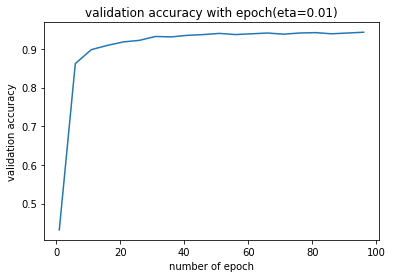

In [55]:
NN=Network([441,100,4])
NN.train(X_train, y_train, X_valid=X_valid, y_valid=y_valid, eta=0.01, lam=0.0, num_epochs=100, isPrint=True, isTen=False)
epochs=NN.epoch
acc=NN.acc
plt.plot(epochs,acc)
plt.xlabel('number of epoch')
plt.ylabel('validation accuracy')
plt.title('validation accuracy with epoch(eta=0.01)')
plt.show()

epoch   1/100:   train acc:    0.937  valid acc:    0.915
epoch   6/100:   train acc:    0.976  valid acc:    0.942
epoch  11/100:   train acc:    0.985  valid acc:    0.951
epoch  16/100:   train acc:    0.987  valid acc:    0.952
epoch  21/100:   train acc:    0.991  valid acc:    0.952
epoch  26/100:   train acc:    0.992  valid acc:    0.956
epoch  31/100:   train acc:    0.994  valid acc:    0.958
epoch  36/100:   train acc:    0.994  valid acc:    0.955
epoch  41/100:   train acc:    0.994  valid acc:    0.957
epoch  46/100:   train acc:    0.995  valid acc:    0.960
epoch  51/100:   train acc:    0.995  valid acc:    0.958
epoch  56/100:   train acc:    0.995  valid acc:    0.959
epoch  61/100:   train acc:    0.995  valid acc:    0.960
epoch  66/100:   train acc:    0.995  valid acc:    0.961
epoch  71/100:   train acc:    0.995  valid acc:    0.959
epoch  76/100:   train acc:    0.995  valid acc:    0.961
epoch  81/100:   train acc:    0.995  valid acc:    0.960
epoch  86/100:

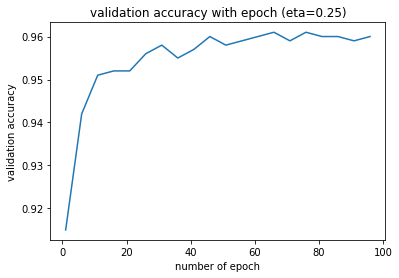

In [65]:
NN=Network([441,100,4])
NN.train(X_train, y_train, X_valid=X_valid, y_valid=y_valid, eta=0.25, lam=0.0, num_epochs=100, isPrint=True, isTen=False)
epochs=NN.epoch
acc=NN.acc
plt.plot(epochs,acc)
plt.xlabel('number of epoch')
plt.ylabel('validation accuracy')
plt.title('validation accuracy with epoch (eta=0.25)')
plt.show()

epoch   1/100:   train acc:    0.695  valid acc:    0.686
epoch   6/100:   train acc:    0.879  valid acc:    0.878
epoch  11/100:   train acc:    0.975  valid acc:    0.955
epoch  16/100:   train acc:    0.979  valid acc:    0.955
epoch  21/100:   train acc:    0.978  valid acc:    0.952
epoch  26/100:   train acc:    0.987  valid acc:    0.958
epoch  31/100:   train acc:    0.986  valid acc:    0.952
epoch  36/100:   train acc:    0.980  valid acc:    0.942
epoch  41/100:   train acc:    0.983  valid acc:    0.957
epoch  46/100:   train acc:    0.991  valid acc:    0.961
epoch  51/100:   train acc:    0.993  valid acc:    0.960
epoch  56/100:   train acc:    0.987  valid acc:    0.961
epoch  61/100:   train acc:    0.993  valid acc:    0.968
epoch  66/100:   train acc:    0.988  valid acc:    0.956
epoch  71/100:   train acc:    0.993  valid acc:    0.959
epoch  76/100:   train acc:    0.993  valid acc:    0.968
epoch  81/100:   train acc:    0.994  valid acc:    0.962
epoch  86/100:

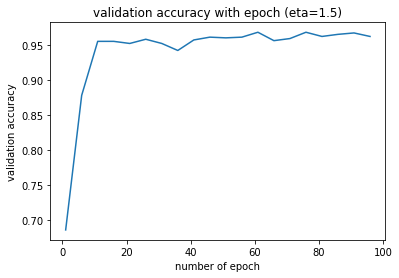

In [66]:
NN=Network([441,100,4])
NN.train(X_train, y_train, X_valid=X_valid, y_valid=y_valid, eta=1.5, lam=0.0, num_epochs=100, isPrint=True, isTen=False)
epochs=NN.epoch
acc=NN.acc
plt.plot(epochs,acc)
plt.xlabel('number of epoch')
plt.ylabel('validation accuracy')
plt.title('validation accuracy with epoch (eta=1.5)')
plt.show()

When learning rate equals to 1.5, the network has the best performance. The best accuracy achieved on the validation dataset is 0.967.

**Part D**:  Now let's see if we can get better results with regularization. Using the best learning rate you found in **Part C**, on a single set of axes, plot the **validation accuracy** vs epoch for networks trained on the full training set for at least 50 epochs using the regularization strengths $\lambda = 10^{-6}$, $\lambda = 10^{-4}$ and $\lambda = 10^{-2}$.  Which regularization strength seems to perform the best? What is the best accuracy achieved on the validation set?   

epoch   1/100:   train acc:    0.906  valid acc:    0.908
epoch   6/100:   train acc:    0.957  valid acc:    0.942
epoch  11/100:   train acc:    0.975  valid acc:    0.949
epoch  16/100:   train acc:    0.977  valid acc:    0.950
epoch  21/100:   train acc:    0.979  valid acc:    0.959
epoch  26/100:   train acc:    0.972  valid acc:    0.943
epoch  31/100:   train acc:    0.993  valid acc:    0.970
epoch  36/100:   train acc:    0.989  valid acc:    0.964
epoch  41/100:   train acc:    0.992  valid acc:    0.959
epoch  46/100:   train acc:    0.993  valid acc:    0.965
epoch  51/100:   train acc:    0.994  valid acc:    0.969
epoch  56/100:   train acc:    0.993  valid acc:    0.962
epoch  61/100:   train acc:    0.990  valid acc:    0.956
epoch  66/100:   train acc:    0.997  valid acc:    0.966
epoch  71/100:   train acc:    0.997  valid acc:    0.972
epoch  76/100:   train acc:    0.997  valid acc:    0.972
epoch  81/100:   train acc:    0.997  valid acc:    0.975
epoch  86/100:

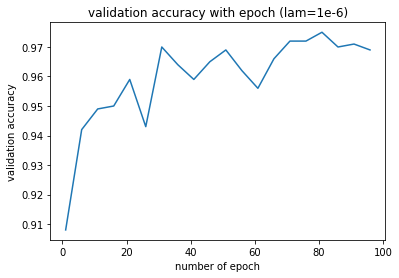

In [67]:
NN=Network([441,100,4])
NN.train(X_train, y_train, X_valid=X_valid, y_valid=y_valid, eta=1.5, lam=1e-6, num_epochs=100, isPrint=True, isTen=False)
epochs=NN.epoch
acc=NN.acc
plt.plot(epochs,acc)
plt.xlabel('number of epoch')
plt.ylabel('validation accuracy')
plt.title('validation accuracy with epoch (lam=1e-6)')
plt.show()

epoch   1/100:   train acc:    0.901  valid acc:    0.890
epoch   6/100:   train acc:    0.963  valid acc:    0.949
epoch  11/100:   train acc:    0.964  valid acc:    0.948
epoch  16/100:   train acc:    0.958  valid acc:    0.939
epoch  21/100:   train acc:    0.973  valid acc:    0.961
epoch  26/100:   train acc:    0.970  valid acc:    0.952
epoch  31/100:   train acc:    0.958  valid acc:    0.943
epoch  36/100:   train acc:    0.966  valid acc:    0.954
epoch  41/100:   train acc:    0.965  valid acc:    0.947
epoch  46/100:   train acc:    0.962  valid acc:    0.940
epoch  51/100:   train acc:    0.960  valid acc:    0.934
epoch  56/100:   train acc:    0.966  valid acc:    0.950
epoch  61/100:   train acc:    0.958  valid acc:    0.944
epoch  66/100:   train acc:    0.896  valid acc:    0.874
epoch  71/100:   train acc:    0.928  valid acc:    0.906
epoch  76/100:   train acc:    0.969  valid acc:    0.948
epoch  81/100:   train acc:    0.964  valid acc:    0.940
epoch  86/100:

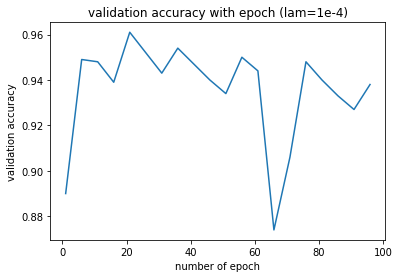

In [68]:
NN=Network([441,100,4])
NN.train(X_train, y_train, X_valid=X_valid, y_valid=y_valid, eta=1.5, lam=1e-4, num_epochs=100, isPrint=True, isTen=False)
epochs=NN.epoch
acc=NN.acc
plt.plot(epochs,acc)
plt.xlabel('number of epoch')
plt.ylabel('validation accuracy')
plt.title('validation accuracy with epoch (lam=1e-4)')
plt.show()

epoch   1/100:   train acc:    0.669  valid acc:    0.687
epoch   6/100:   train acc:    0.513  valid acc:    0.511
epoch  11/100:   train acc:    0.630  valid acc:    0.619
epoch  16/100:   train acc:    0.556  valid acc:    0.558
epoch  21/100:   train acc:    0.509  valid acc:    0.520
epoch  26/100:   train acc:    0.488  valid acc:    0.493
epoch  31/100:   train acc:    0.410  valid acc:    0.422
epoch  36/100:   train acc:    0.685  valid acc:    0.695
epoch  41/100:   train acc:    0.630  valid acc:    0.634
epoch  46/100:   train acc:    0.473  valid acc:    0.464
epoch  51/100:   train acc:    0.485  valid acc:    0.496
epoch  56/100:   train acc:    0.474  valid acc:    0.477
epoch  61/100:   train acc:    0.479  valid acc:    0.481
epoch  66/100:   train acc:    0.329  valid acc:    0.346
epoch  71/100:   train acc:    0.429  valid acc:    0.439
epoch  76/100:   train acc:    0.661  valid acc:    0.662
epoch  81/100:   train acc:    0.592  valid acc:    0.604
epoch  86/100:

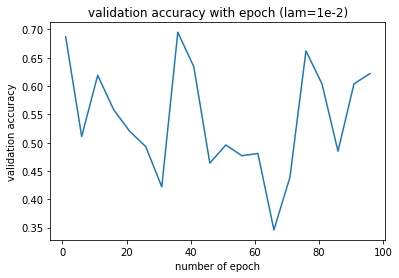

In [69]:
NN=Network([441,100,4])
NN.train(X_train, y_train, X_valid=X_valid, y_valid=y_valid, eta=1.5, lam=1e-2, num_epochs=100, isPrint=True, isTen=False)
epochs=NN.epoch
acc=NN.acc
plt.plot(epochs,acc)
plt.xlabel('number of epoch')
plt.ylabel('validation accuracy')
plt.title('validation accuracy with epoch (lam=1e-2)')
plt.show()

When lambda equals to 1e-6, the network has the best performance. The best accuracy achieved on the validation dataset is 0.972.

**Part E**:  Now let's see if we can get better results with different network architectures. On a single set of axes, plot the **validation accuracy** vs epoch for networks trained on the full training set for at least 50 epochs using the architecture from **Part D** as well as two other architectures.  Which architecture seems to perform the best? What is the best accuracy achieved on the validation set?   

epoch   1/100:   train acc:    0.858  valid acc:    0.849
epoch   6/100:   train acc:    0.968  valid acc:    0.948
epoch  11/100:   train acc:    0.974  valid acc:    0.954
epoch  16/100:   train acc:    0.981  valid acc:    0.958
epoch  21/100:   train acc:    0.985  valid acc:    0.955
epoch  26/100:   train acc:    0.987  valid acc:    0.964
epoch  31/100:   train acc:    0.991  valid acc:    0.950
epoch  36/100:   train acc:    0.991  valid acc:    0.956
epoch  41/100:   train acc:    0.976  valid acc:    0.943
epoch  46/100:   train acc:    0.993  valid acc:    0.962
epoch  51/100:   train acc:    0.994  valid acc:    0.959
epoch  56/100:   train acc:    0.992  valid acc:    0.960
epoch  61/100:   train acc:    0.992  valid acc:    0.959
epoch  66/100:   train acc:    0.994  valid acc:    0.963
epoch  71/100:   train acc:    0.995  valid acc:    0.972
epoch  76/100:   train acc:    0.993  valid acc:    0.953
epoch  81/100:   train acc:    0.995  valid acc:    0.972
epoch  86/100:

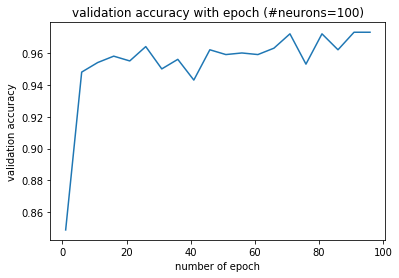

In [11]:
NN=Network([441,100,4])
NN.train(X_train, y_train, X_valid=X_valid, y_valid=y_valid, eta=1.5, lam=1e-6, num_epochs=100, isPrint=True, isTen=False)
epochs=NN.epoch
acc=NN.acc
plt.plot(epochs,acc)
plt.xlabel('number of epoch')
plt.ylabel('validation accuracy')
plt.title('validation accuracy with epoch (#neurons=100)')
plt.show()

epoch   1/100:   train acc:    0.913  valid acc:    0.894
epoch   6/100:   train acc:    0.959  valid acc:    0.935
epoch  11/100:   train acc:    0.973  valid acc:    0.942
epoch  16/100:   train acc:    0.978  valid acc:    0.949
epoch  21/100:   train acc:    0.971  valid acc:    0.949
epoch  26/100:   train acc:    0.974  valid acc:    0.937
epoch  31/100:   train acc:    0.974  valid acc:    0.954
epoch  36/100:   train acc:    0.984  valid acc:    0.946
epoch  41/100:   train acc:    0.989  valid acc:    0.956
epoch  46/100:   train acc:    0.993  valid acc:    0.964
epoch  51/100:   train acc:    0.992  valid acc:    0.964
epoch  56/100:   train acc:    0.994  valid acc:    0.966
epoch  61/100:   train acc:    0.994  valid acc:    0.959
epoch  66/100:   train acc:    0.995  valid acc:    0.961
epoch  71/100:   train acc:    0.995  valid acc:    0.965
epoch  76/100:   train acc:    0.995  valid acc:    0.968
epoch  81/100:   train acc:    0.996  valid acc:    0.967
epoch  86/100:

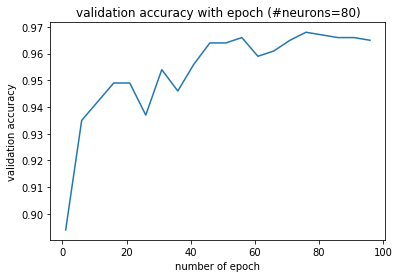

In [ ]:
NN=Network([441,30,4])
NN.train(X_train, y_train, X_valid=X_valid, y_valid=y_valid, eta=1.5, lam=1e-6, num_epochs=100, isPrint=True, isTen=False)
epochs=NN.epoch
acc=NN.acc
plt.plot(epochs,acc)
plt.xlabel('number of epoch')
plt.ylabel('validation accuracy')
plt.title('validation accuracy with epoch (#neurons=30)')
plt.show()

epoch   1/100:   train acc:    0.253  valid acc:    0.255
epoch   6/100:   train acc:    0.440  valid acc:    0.421
epoch  11/100:   train acc:    0.513  valid acc:    0.500
epoch  16/100:   train acc:    0.553  valid acc:    0.556
epoch  21/100:   train acc:    0.740  valid acc:    0.729
epoch  26/100:   train acc:    0.827  valid acc:    0.809
epoch  31/100:   train acc:    0.865  valid acc:    0.858
epoch  36/100:   train acc:    0.812  valid acc:    0.804
epoch  41/100:   train acc:    0.917  valid acc:    0.906
epoch  46/100:   train acc:    0.889  valid acc:    0.873
epoch  51/100:   train acc:    0.953  valid acc:    0.938
epoch  56/100:   train acc:    0.953  valid acc:    0.934
epoch  61/100:   train acc:    0.971  valid acc:    0.954
epoch  66/100:   train acc:    0.966  valid acc:    0.949
epoch  71/100:   train acc:    0.897  valid acc:    0.879
epoch  76/100:   train acc:    0.850  valid acc:    0.825
epoch  81/100:   train acc:    0.776  valid acc:    0.752
epoch  86/100:

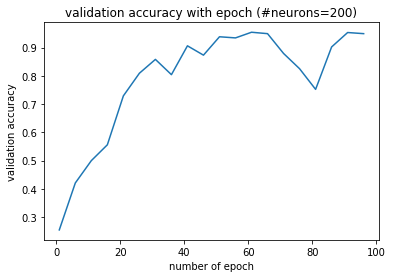

In [13]:
NN=Network([441,400,4])
NN.train(X_train, y_train, X_valid=X_valid, y_valid=y_valid, eta=1.5, lam=1e-6, num_epochs=100, isPrint=True, isTen=False)
epochs=NN.epoch
acc=NN.acc
plt.plot(epochs,acc)
plt.xlabel('number of epoch')
plt.ylabel('validation accuracy')
plt.title('validation accuracy with epoch (#neurons=200)')
plt.show()

I tried three architectures, they all have single hidden layer but the number of neurons is differnt(the number is 30, 100 and 400) . When the only hidden layer has 100 neurons, the network has the best performance. The best accuracy achieved on the validation dataset is 0.973.

### [max 20 points] Extra Credit: Improving Network Performance 
***

See if you can get better performance by exploring advanced techniques.  Things you might try are: 

- Implementing **Mini-Batch** Stochastic Gradient Descent 
- Experimenting with different activation functions (like tanh and **Leaky** ReLU)
- Experimenting with different loss functions (like cross-entropy) 

For more detailed discussion of these techniques it'll be helpful to look at Chapter 3 of [Nielsen](http://neuralnetworksanddeeplearning.com/chap3.html). 

The amount of extra credit you receive will be proportional to the number of above suggested tasks that you complete.  Further, to receive credit for the tasks you must not only implement, but also provide evidence that you've tuned the network to make it work.  Comment on the performance differences between the original `Network` implementation and your new networks with bells and whistles. 

**Important Note**: Don't do any of these things in the original `Network` class, because you'll almost certainly break the unit tests.  Copy the `Network` class from above and rename it `BetterNetwork` (or something) and modify the new class. 
